In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

In [3]:
import src.ftrs.feature_generator as fgen
import src.mex.regions2010 as mex_region
import src.mex.census2010 as mex_census
import src.mex.crime as mex_crime
from tinydb import TinyDB
import pandas as pd
import src.exp.preprocessing as exp_prep
import sklearn.preprocessing as sk_prep
import exp_pred_muni_crime as exp_predc
import src.exp.sklearn_models as exp_sk
%matplotlib inline

from collections import defaultdict

import matplotlib.pyplot as plt

import datetime

import sklearn
sklearn.__version__



'0.22.1'

In [4]:
settings = {
    0: ('Urban', 'grid-500', 'Uni'),  # done
    1: ('Urban', 'grid-500', 'Pop'),  # done
    2: ('UrbanRural', 'grid-500', 'Uni'),  # running
    3: ('Urban', 'ageb', 'Uni'),
    4: ('Urban', 'ageb', 'Pop'),
}

boundary_type, su_type, intpl = settings[0]
print(boundary_type, su_type, intpl)
db_path = 'data/features_database.json'

Urban grid-500 Uni


# load data

In [5]:
crimes = exp_predc.load_crime()

In [6]:
crimes.head()

,#pro,#vio,%pro,%vio
mun_id,,,,
01001,3963.0,7041.0,49.723341,88.342681
01002,54.0,143.0,11.870219,31.434098
01003,43.0,91.0,7.942958,16.809517
01004,30.0,54.0,19.944156,35.899481
01005,338.0,558.0,33.939151,56.029722


In [7]:
mgms = mex_region.municipalities(load_pop=True)


In [8]:
features = exp_predc.load_feature(db_path, boundary_type, su_type, intpl, mun_ids=crimes.index)
features = exp_prep.fillna(features)

In [9]:
poverty = mex_census.poverty_munic(kind='poverty', rate=True)
econ_unoccupied = mex_census.econ_active_unoccupied(rate=True)

In [10]:
to_r=crimes[['#pro']].join( features[['loubar-NHS-all_day','loubar-PROX-all_day','loubar-COMP-all_day']])
to_r.columns=['pro_cnt','nhs','prox','comp']
to_r = to_r.join(poverty).join(econ_unoccupied)

In [11]:
to_r.index.name='Identifier'

In [12]:
to_r['popu'] = mgms.pobtot

In [91]:
to_r.to_csv('crimes_data_pop.csv')

# individual feature correlation

In [20]:
from scipy.stats import pearsonr, spearmanr, kendalltau
stests = {'pear': pearsonr, 'spear':spearmanr, 'kend': kendalltau}

In [14]:
# correlations with crime count
def run_correlations(crimes, features):
    corrs = defaultdict(lambda : defaultdict(dict))
    pvals = defaultdict(lambda : defaultdict(dict))
    for cname in crimes:
        crate = crimes[cname]
        for fname in features:
            ftr = features[fname]
            for sname, stest in stests.items():
                corr, pv = stest(crate, ftr)
                corrs[sname][cname][fname] = corr
                pvals[sname][cname][fname] = pv
    return corrs, pvals

In [15]:
def plot_by_diff_corr(corrs,pvals=None):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(6,3))
    for i, sname in enumerate(stests.keys()):
        ax = axes[i]
        tmp_corr = pd.DataFrame(corrs[sname])
        if pvals is None:
            tmp_corr.plot(kind='box', ax=ax)
        else:
            tmp_pval = pd.DataFrame(pvals[sname])
            tmp_corr[tmp_pval<0.05].plot(kind='box', ax=ax)
        ax.set_title(sname)


In [16]:
def plot_by_feature_groups(corrs, pvals=None):
    fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(6,3))
    if pvals is not None:
        corrs = corrs[pvals<=0.05]
        
    ax=axes[0]
    ax.set_title('hotspot scale')
    corrs[corrs.index.str.contains('HS-')].plot(kind='box', ax=ax)

    ax=axes[1]
    ax.set_title('urban sprawl')
    corrs[corrs.index.str.contains('COMP')].plot(kind='box', ax=ax)

    ax=axes[2]
    ax.set_title('urban compactness')
    corrs[(~corrs.index.str.contains('COMP')) &(~corrs.index.str.contains('HS-'))].plot(kind='box', ax=ax)


In [17]:
sig_only = True

True Urban ageb Uni
# not sig. {'#pro': 0, '#vio': 0, '%pro': 0, '%vio': 0}


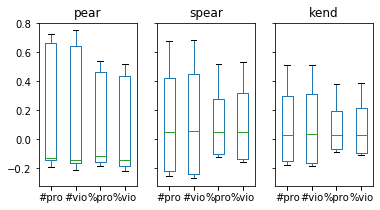

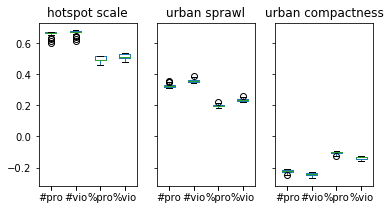

In [532]:
# Urban ageb Uni
boundary_type, su_type, intpl = settings[3]
db_path = 'data/features_database_tmp.json'
print(sig_only, boundary_type, su_type, intpl)

features = exp_predc.load_feature(db_path, boundary_type, su_type, intpl, mun_ids=crimes.index)
features = exp_prep.fillna(features)

corrs, pvals = run_correlations(crimes, features)
tmp  =pd.DataFrame(corrs['spear'])

tmp_pval = pd.DataFrame(pvals['spear'])
print('# not sig.', (tmp_pval>0.05).sum().to_dict())

if sig_only:
    plot_by_diff_corr(corrs, pvals)
    plot_by_feature_groups(tmp, tmp_pval)
else:
    plot_by_diff_corr(corrs)
    plot_by_feature_groups(tmp)

True UrbanRural grid-500 Uni
# not sig. {'#pro': 47, '#vio': 104, '%pro': 72, '%vio': 108}


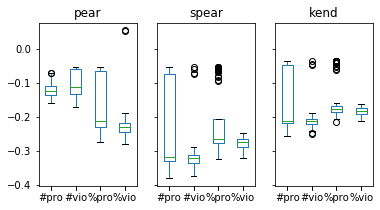

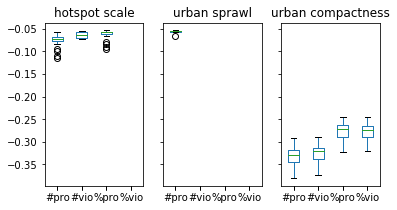

In [533]:
# UrbanRural grid-500 Uni
boundary_type, su_type, intpl = settings[2]
db_path = 'data/features_database.json'
print(sig_only, boundary_type, su_type, intpl)

features = exp_predc.load_feature(db_path, boundary_type, su_type, intpl, mun_ids=crimes.index)
features = exp_prep.fillna(features)

corrs, pvals = run_correlations(crimes, features)
tmp  =pd.DataFrame(corrs['spear'])

tmp_pval = pd.DataFrame(pvals['spear'])
print('# not sig.', (tmp_pval>0.05).sum().to_dict())

if sig_only:
    plot_by_diff_corr(corrs, pvals)
    plot_by_feature_groups(tmp, tmp_pval)
else:
    plot_by_diff_corr(corrs)
    plot_by_feature_groups(tmp)

True Urban grid-500 Uni
# not sig. {'#pro': 49, '#vio': 25, '%pro': 45, '%vio': 54}


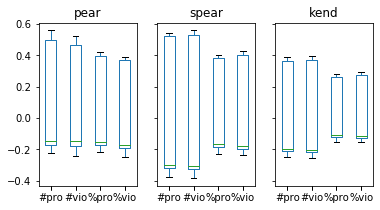

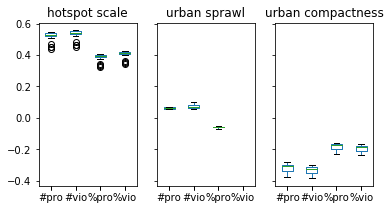

In [21]:
# Urban grid-500 Uni
boundary_type, su_type, intpl = settings[0]
db_path = 'data/features_database.json'
print(sig_only, boundary_type, su_type, intpl)

features = exp_predc.load_feature(db_path, boundary_type, su_type, intpl, mun_ids=crimes.index)
features = exp_prep.fillna(features)

corrs, pvals = run_correlations(crimes, features)
tmp  =pd.DataFrame(corrs['spear'])

tmp_pval = pd.DataFrame(pvals['spear'])
print('# not sig.', (tmp_pval>0.05).sum().to_dict())

if sig_only:
    plot_by_diff_corr(corrs, pvals)
    plot_by_feature_groups(tmp, tmp_pval)
else:
    plot_by_diff_corr(corrs)
    plot_by_feature_groups(tmp)

True Urban grid-500 Pop
# not sig. {'#pro': 0, '#vio': 0, '%pro': 0, '%vio': 0}


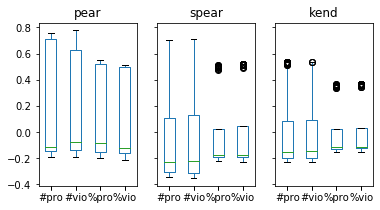

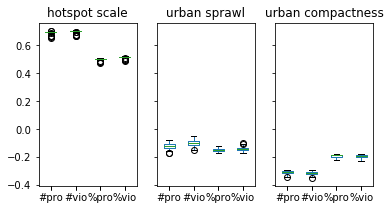

In [535]:
# Urban grid-500 Pop
boundary_type, su_type, intpl = settings[1]
db_path = 'data/features_database_tmp.json'
print(sig_only, boundary_type, su_type, intpl)

features = exp_predc.load_feature(db_path, boundary_type, su_type, intpl, mun_ids=crimes.index)
features = exp_prep.fillna(features)

corrs, pvals = run_correlations(crimes, features)
tmp  =pd.DataFrame(corrs['spear'])

tmp_pval = pd.DataFrame(pvals['spear'])
print('# not sig.', (tmp_pval>0.05).sum().to_dict())

if sig_only:
    plot_by_diff_corr(corrs, pvals)
    plot_by_feature_groups(tmp, tmp_pval)
else:
    plot_by_diff_corr(corrs)
    plot_by_feature_groups(tmp)

# modeling

In [22]:
crime_cols = crimes.columns.tolist()

In [23]:
sheet_names=[c+'-hourF' for c in crime_cols] + [c+'-hourT' for c in crime_cols]

In [24]:
def extract_best_test_result(excel_sheet):
    df = excel_sheet
    best_test_result = {
        'RMSE': f'{df.test_RMSE.min():.2f} ({df.test_RMSE.idxmin()})',
        'MAE': f'{df.test_MAE.min():.2f} ({df.test_MAE.idxmin()})',
        'spea': f'{df.test_spea_cor.max():.2f} ({df.test_spea_cor.idxmax()})',
        'r2': f'{df.test_r2.max():.2f} ({df.test_r2.idxmax()})'
    }
    return best_test_result

In [25]:
def extract_result_for_one_sheet_name(sheet_name):

    results = {}
    for boundary_type, su_type, intpl in settings.values():
        path = f'exp_result/muni_crime-{boundary_type}-{su_type}-{intpl}-{scaling}.xlsx'
        if not os.path.exists(path):
            continue
        df = pd.read_excel(path, sheet_name=sheet_name, index_col=0)
        results[f'{boundary_type}-{su_type}-{intpl}'] = extract_best_test_result(df)
    results = pd.DataFrame(results)    
    results.index.name = sheet_name
    return results

Different feature sets have different performance. Urban seems to be better than UrbRur(but so far there is only 1 urbrur set). 

pop seems to be better than Uni most of the time

ageb vs grid may be 50/50, 


Relating to the Sensitivity analysis: 
- The boundary setting matters. It need to be consistent
- in Urban settings. (Ageb grid ) x (uni, pop) seems to provide stable results

In [26]:
scaling = 'StandardScaler'
sheet_name = sheet_names[0]
extract_result_for_one_sheet_name(sheet_name)

,UrbanRural-grid-500-Uni,Urban-grid-500-Uni,Urban-grid-500-Pop,Urban-ageb-Uni,Urban-ageb-Pop
#pro-hourF,,,,,
RMSE,769.25 (RFreg),516.73 (GDBreg),599.93 (lasso),520.24 (BAGreg),527.55 (DTreg)
MAE,180.39 (SVR),145.30 (GDBreg),149.44 (GDBreg),137.22 (BAGreg),120.37 (GDBreg)
spea,0.43 (SVR),0.63 (linearSVR),0.67 (BAGreg),0.66 (BAGreg),0.66 (ADAreg)
r2,0.16 (RFreg),0.62 (GDBreg),0.49 (lasso),0.61 (BAGreg),0.60 (DTreg)


In [585]:
scaling = 'StandardScaler'
sheet_name = sheet_names[1]
extract_result_for_one_sheet_name(sheet_name)

,UrbanRural-grid-500-Uni,Urban-grid-500-Uni,Urban-grid-500-Pop,Urban-ageb-Uni,Urban-ageb-Pop
#vio-hourF,,,,,
RMSE,1889.48 (BAGreg),1354.28 (linearSVR),1020.75 (ols),1115.13 (lasso),930.18 (GDBreg)
MAE,392.05 (SVR),291.59 (RFreg),276.37 (RFreg),284.29 (GDBreg),234.75 (GDBreg)
spea,0.40 (SVR),0.61 (ADAreg),0.68 (RFreg),0.67 (BAGreg),0.68 (ADAreg)
r2,0.07 (BAGreg),0.52 (linearSVR),0.73 (ols),0.68 (lasso),0.78 (GDBreg)


In [586]:
scaling = 'StandardScaler'
sheet_name = sheet_names[2]
extract_result_for_one_sheet_name(sheet_name)

,UrbanRural-grid-500-Uni,Urban-grid-500-Uni,Urban-grid-500-Pop,Urban-ageb-Uni,Urban-ageb-Pop
%pro-hourF,,,,,
RMSE,14.99 (GDBreg),13.33 (RFreg),14.02 (ADAreg),13.24 (ADAreg),13.18 (RFreg)
MAE,9.87 (SVR),9.45 (SVR),9.32 (SVR),9.28 (SVR),8.90 (SVR)
spea,0.35 (SVR),0.49 (GDBreg),0.50 (GDBreg),0.47 (ols),0.52 (RFreg)
r2,0.09 (GDBreg),0.28 (RFreg),0.20 (ADAreg),0.29 (ADAreg),0.30 (RFreg)


In [587]:
scaling = 'StandardScaler'
sheet_name = sheet_names[3]
extract_result_for_one_sheet_name(sheet_name)

,UrbanRural-grid-500-Uni,Urban-grid-500-Uni,Urban-grid-500-Pop,Urban-ageb-Uni,Urban-ageb-Pop
%vio-hourF,,,,,
RMSE,29.15 (GDBreg),26.06 (GDBreg),25.19 (ridge),24.69 (ols),24.46 (DTreg)
MAE,20.05 (SVR),19.05 (GDBreg),18.18 (linearSVR),18.13 (linearSVR),17.62 (DTreg)
spea,0.34 (SVR),0.46 (GDBreg),0.46 (GDBreg),0.48 (linearSVR),0.53 (lasso)
r2,0.07 (GDBreg),0.25 (GDBreg),0.30 (ridge),0.33 (ols),0.34 (DTreg)


In [588]:
scaling = 'StandardScaler'
sheet_name = sheet_names[4]
extract_result_for_one_sheet_name(sheet_name)

,UrbanRural-grid-500-Uni,Urban-grid-500-Uni,Urban-grid-500-Pop,Urban-ageb-Uni,Urban-ageb-Pop
#pro-hourT,,,,,
RMSE,808.67 (GDBreg),636.51 (lasso),561.53 (ridge),453.21 (BAGreg),499.05 (RFreg)
MAE,180.25 (SVR),147.75 (GDBreg),136.03 (RFreg),131.31 (RFreg),115.29 (RFreg)
spea,0.43 (SVR),0.62 (lasso),0.68 (RFreg),0.65 (RFreg),0.67 (RFreg)
r2,0.07 (GDBreg),0.42 (lasso),0.55 (ridge),0.71 (BAGreg),0.65 (RFreg)


In [589]:
scaling = 'StandardScaler'
sheet_name = sheet_names[5]
extract_result_for_one_sheet_name(sheet_name)

,UrbanRural-grid-500-Uni,Urban-grid-500-Uni,Urban-grid-500-Pop,Urban-ageb-Uni,Urban-ageb-Pop
#vio-hourT,,,,,
RMSE,1903.09 (ridge),1183.62 (ridge),1031.91 (ridge),1140.40 (linearSVR),1190.98 (ridge)
MAE,391.77 (SVR),293.35 (RFreg),255.49 (DTreg),267.97 (RFreg),253.41 (RFreg)
spea,0.42 (SVR),0.61 (RFreg),0.68 (RFreg),0.66 (BAGreg),0.70 (lasso)
r2,0.06 (ridge),0.64 (ridge),0.72 (ridge),0.66 (linearSVR),0.63 (ridge)


## same setting for R model

In [13]:
import warnings
from sklearn.exceptions import ConvergenceWarning
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore", category=(ConvergenceWarning, UserWarning))
    os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses


In [63]:
training = to_r.iloc[:1103].copy()
testing = to_r.iloc[1103:].copy()

nhs_min = training.nhs.min()
nhs_range = training.nhs.max()-nhs_min

training.nhs = (training.nhs - nhs_min) / nhs_range
testing.nhs = (testing.nhs - nhs_min) / nhs_range

### without socio-econ

In [64]:
train_X = training[['nhs','prox','comp']].values
train_Y = training['pro_cnt'].values
test_X = testing[['nhs','prox','comp']].values
test_Y = testing['pro_cnt'].values
dataset = (train_X, test_X, train_Y, test_Y)

In [65]:
model_names = [
    'ols', 'ridge', 'lasso', 'DTreg', 'SVR', 'linearSVR', 'ADAreg', 'GDBreg', 'RFreg', 'BAGreg', 'XGBreg',
]
res = exp_predc.train_eval_models(model_names, dataset, verbose=1, n_iter=20)


ran ols, using 0.010763 seconds
ran ridge, using 0.089506 seconds
ran lasso, using 0.083677 seconds
ran DTreg, using 0.197039 seconds
ran SVR, using 0.096247 seconds
ran linearSVR, using 0.577706 seconds
ran ADAreg, using 46.178828 seconds
ran GDBreg, using 45.87721 seconds
ran RFreg, using 74.533487 seconds
ran BAGreg, using 82.576938 seconds
ran XGBreg, using 100.542321 seconds


In [66]:
pd.DataFrame(res).T.sort_values('test_RMSE')

,train_time,test_RMSE,test_MAE,test_Exp_var,test_r2,test_pear_cor,test_spea_cor,test_kend_cor,train_RMSE,train_MAE,train_Exp_var,train_r2,train_pear_cor,train_spea_cor,train_kend_cor
RFreg,74.533487,607.053264,231.332833,0.275420,0.264544,0.664417,0.702374,0.514705,544.180906,114.165140,0.782974,0.782926,0.910785,0.828683,0.667281
BAGreg,82.576938,615.368939,227.951572,0.252406,0.244257,0.650388,0.687540,0.504202,346.311480,75.561776,0.912144,0.912087,0.972019,0.875836,0.736904
ADAreg,46.178828,655.505520,358.921243,0.230700,0.142457,0.602846,0.425264,0.299480,492.250576,328.422496,0.844752,0.822379,0.929309,0.403308,0.286796
linearSVR,0.577706,680.261034,351.768893,0.085506,0.076463,0.319266,0.521023,0.362574,1088.828589,378.561582,0.130966,0.130959,0.368083,0.535045,0.381187
ridge,0.089506,682.450660,356.322978,0.080695,0.070508,0.317063,0.518624,0.360934,1088.473551,382.232617,0.131526,0.131526,0.367524,0.535081,0.381204
lasso,0.083677,685.090296,372.989638,0.076927,0.063304,0.342984,0.537395,0.374798,1084.412471,404.931037,0.137994,0.137994,0.371567,0.542144,0.384858
ols,0.010763,686.718056,376.264792,0.072954,0.058847,0.344214,0.538204,0.375221,1084.364140,408.877247,0.138071,0.138071,0.371579,0.542778,0.385312
GDBreg,45.877210,699.652641,261.816234,0.032025,0.023059,0.621559,0.586879,0.420728,352.080400,70.982537,0.909135,0.909133,0.958874,0.803928,0.660600
SVR,0.096247,742.178234,233.788325,0.005372,-0.099309,0.243076,0.448813,0.310771,1191.899887,262.311187,0.005231,-0.041360,0.351356,0.519720,0.372713
XGBreg,100.542321,752.634063,431.949480,-0.125331,-0.130501,0.624852,0.323880,0.222237,620.911385,211.298831,0.717451,0.717395,0.848189,0.346156,0.242950


In [50]:
s = """
      a[1]        a[2]        a[3]        a[4]        a[5]        a[6]        a[7]           b       sigma     epsilon 
 -5.8041127  -7.9620936   2.8651904  21.6222203   0.1954955  17.0649575 -10.8402757  10.3699885   9.2303468   0.4609099 
""".strip().split('\n')
s = [f'"{a}"={b}' for a, b in zip(s[0].split(), s[1].split())]

In [51]:
print('post_mean_alpha=c('+','.join(s[:7])+')')
print('post_mean_beta=c('+s[7]+')')

post_mean_alpha=c("a[1]"=-5.8041127,"a[2]"=-7.9620936,"a[3]"=2.8651904,"a[4]"=21.6222203,"a[5]"=0.1954955,"a[6]"=17.0649575,"a[7]"=-10.8402757)
post_mean_beta=c("b"=10.3699885)


### with socio-econ

In [67]:
train_X = training[['nhs','prox','comp','poverty_rate','active_unoccupied']].values
train_Y = training['pro_cnt'].values
test_X = testing[['nhs','prox','comp','poverty_rate','active_unoccupied']].values
test_Y = testing['pro_cnt'].values
dataset = (train_X, test_X, train_Y, test_Y)

In [68]:
model_names = [
    'ols', 'ridge', 'lasso', 'DTreg', 'SVR', 'linearSVR', 'ADAreg', 'GDBreg', 'RFreg', 'BAGreg', 'XGBreg',
]
res = exp_predc.train_eval_models(model_names, dataset, verbose=1, n_iter=20)


ran ols, using 0.010337 seconds
ran ridge, using 0.08784 seconds
ran lasso, using 0.078919 seconds
ran DTreg, using 0.266573 seconds
ran SVR, using 0.101005 seconds
ran linearSVR, using 1.05961 seconds
ran ADAreg, using 53.675495 seconds
ran GDBreg, using 70.25168 seconds
ran RFreg, using 104.426564 seconds
ran BAGreg, using 116.293119 seconds
ran XGBreg, using 120.39081 seconds


In [69]:
pd.DataFrame(res).T.sort_values('test_RMSE')

,train_time,test_RMSE,test_MAE,test_Exp_var,test_r2,test_pear_cor,test_spea_cor,test_kend_cor,train_RMSE,train_MAE,train_Exp_var,train_r2,train_pear_cor,train_spea_cor,train_kend_cor
ADAreg,53.675495,528.768151,250.925629,0.472216,0.442001,0.700642,0.501415,0.352179,509.120713,267.203515,0.818343,0.809996,0.911929,0.663116,0.489628
RFreg,104.426564,554.035096,206.654911,0.392082,0.387399,0.685271,0.621474,0.442261,525.140812,117.206253,0.797852,0.797850,0.921933,0.872147,0.721480
BAGreg,116.293119,575.343562,209.361014,0.344700,0.339371,0.658415,0.595141,0.421790,382.081378,89.372421,0.892988,0.892988,0.963707,0.894313,0.758954
GDBreg,70.251680,577.788980,228.438786,0.338672,0.333743,0.680624,0.597545,0.429095,106.025926,17.967995,0.991760,0.991760,0.997282,0.945182,0.863447
XGBreg,120.390810,588.385416,330.189366,0.320050,0.309081,0.723629,0.427154,0.302349,442.771949,166.266213,0.856292,0.856292,0.938294,0.478598,0.342402
linearSVR,1.059610,671.288958,389.276260,0.130351,0.100663,0.374344,0.559390,0.386741,1078.224316,421.426687,0.147878,0.147804,0.386954,0.655274,0.479952
ridge,0.087840,673.981744,393.530630,0.126950,0.093434,0.370889,0.555325,0.384943,1078.164244,421.661834,0.147899,0.147899,0.387078,0.651327,0.477030
lasso,0.078919,677.317499,398.053122,0.120379,0.084438,0.384063,0.570091,0.395888,1074.617981,432.293625,0.153495,0.153495,0.391849,0.648768,0.472303
ols,0.010337,678.970725,399.686996,0.116221,0.079963,0.384071,0.571540,0.397739,1074.566393,434.479727,0.153576,0.153576,0.391888,0.647403,0.471055
SVR,0.101005,734.905333,230.182529,0.014779,-0.077869,0.330685,0.377039,0.262057,1187.912439,259.647865,0.009210,-0.034404,0.284188,0.593210,0.422880


#### r results

In [76]:
s = """
        a[1]         a[2]         a[3]         a[4]         a[5]         a[6]         a[7]         b[1]         b[2] 
 -5.78779658  -7.94930753   2.85821812  22.16368477  -0.04204437  18.18094733 -11.49584811   9.97973727   0.36354413 
        b[3]         b[4]         b[5]        sigma      epsilon 
 -0.39893527   0.10308130   0.15207365   9.21999945   0.48841733 
""".strip().split('\n')
s = [f'"{a}"={b}' for a, b in zip(s[0].split()+s[2].split(), s[1].split()+s[3].split())]

print('post_mean_alpha=c('+','.join(s[:7])+')')
print('post_mean_beta=c('+','.join(s[7:12])+')')

post_mean_alpha=c("a[1]"=-5.78779658,"a[2]"=-7.94930753,"a[3]"=2.85821812,"a[4]"=22.16368477,"a[5]"=-0.04204437,"a[6]"=18.18094733,"a[7]"=-11.49584811)
post_mean_beta=c("b[1]"=9.97973727,"b[2]"=0.36354413,"b[3]"=-0.39893527,"b[4]"=0.10308130,"b[5]"=0.15207365)


In [ ]:
# in R:
# Iteration Number: 1.
# Current number of MCMC iterations: 2000.
# Parameter Estimates: 
#        a[1]        a[2]        a[3]        a[4]        a[5]        a[6]        a[7]        b[1]        b[2]        b[3] 
#  -5.8767916  -7.4526059   2.6764095  20.1109117   0.1355685  16.7745085 -10.2415907   9.5276327   0.3589272  -0.3850018 
#        b[4]        b[5]       sigma     epsilon 
#   0.1026905   0.1521712   5.8938482   0.4635740 
# Convergence Criterion: 1.001.

#       rsme         mse         mae 
#    749.9699 562454.8225    247.7645 

In [ ]:
# Iteration Number: 26.
# Current number of MCMC iterations: 2000.
# Parameter Estimates: 
#         a[1]         a[2]         a[3]         a[4]         a[5]         a[6]         a[7]         b[1]         b[2] 
#  -5.78779658  -7.94930753   2.85821812  22.16368477  -0.04204437  18.18094733 -11.49584811   9.97973727   0.36354413 
#         b[3]         b[4]         b[5]        sigma      epsilon 
#  -0.39893527   0.10308130   0.15207365   9.21999945   0.48841733 
# Convergence Criterion: 0.06223755.

#        rsme         mse         mae 
#    749.9696 562454.3659    247.7572 

In [ ]:
# if a, b is the mean of the posteria sample:
#      a[1]       a[2]       a[3]       a[4]       a[5]       a[6]       a[7] 
#   4.442762  21.777251  -9.985775 -26.080971  -2.523635 -12.865193  10.472841 
#       b[1]       b[2]       b[3]       b[4]       b[5] 
#  -1.210216 -40.026336  20.928535   2.709254  -4.652882 
#        rsme         mse         mae 
#    725.6948 526632.9674    227.8225 

In [ ]:
# best results so far
# > post_mean_alpha = apply(posterior_alpha,2,mode_by_density)
# > post_mean_beta =apply(posterior_beta,2,mode_by_density)
# > # lambda, pi without random effects
# > test_lambda = exp(post_mean_alpha %*% t(cbind(1,poly_nhs_test,poly_prox_test,poly_comp_test)))
# > test_pi = expit(post_mean_beta%*%t(cbind(1,poly_poverty_test,poly_unem_test)))
# > # compute for the z
# > post_z_test = t(apply(test_pi*test_lambda,1,function(x)rpois(C_N_test,x)))
# > post_lmse_test=apply(post_z_test,1,function(x) log(mean((x-Cdata_test$pro_cnt)^2)))
# > post_mse_test=apply(post_z_test,1,function(x) mean((x-Cdata_test$pro_cnt)^2))
# > post_rmse_test=apply(post_z_test,1,function(x) sqrt(mean((x-Cdata_test$pro_cnt)^2)))
# > post_mae_test=apply(post_z_test,1,function(x) abs(x-Cdata_test$pro_cnt))
# > c(rsme=mean(post_rmse_test), mse=mean(post_mse_test), mae=mean(post_mae_test))

# b[1] ~ dnorm(1, sd=0.6), burnin=4000*10, iter=8000*10
#        rsme         mse         mae 
#    903.8953 817026.7319    259.1594 

# b[1] ~ dnorm(2, sd=0.6), burnin=4000*50, iter=8000*50
#        rsme         mse         mae 
#    706.4626 499089.4565    223.3116 
# b[1] ~ dnorm(2, sd=0.6), burnin=4000*10, iter=8000*10
#        rsme         mse         mae 
#    762.4804 581376.3986    234.8986 
# b[1] ~ dnorm(2, sd=0.4), burnin=4000*10, iter=8000*10
#        rsme         mse         mae 
#    761.7257 580226.0181    234.3080 

# b[1] ~ dnorm(3,sd=0.4), burnin=4000*10, iter=8000*10
#        rsme         mse         mae 
#    664.8201 441985.8225    215.0181 
# b[1] ~ dnorm(3,sd=0.4),nburnin=4000*70,niter = 8000*70
#        rsme         mse         mae 
#    630.6796 397756.7283    210.6630 
# b[1] ~ dnorm(3,sd=0.2), burnin=4000*10, iter=8000*10
#        rsme         mse         mae 
#    757.1365 573255.6268    234.3732 

# b[1] ~ dnorm(4,sd=0.3), burnin=4000*10, iter=8000*10
#        rsme         mse         mae 
#    659.8383 435386.5290    214.6812 
# b[1] ~ dnorm(4,sd=0.4), burnin=4000*10, iter=8000*10 with different initial values
#        rsme         mse         mae 
#    755.2283 570369.7899    233.2464 

## on Y by bayesian model

In [86]:
true_crime = pd.read_csv('data/dnorm-posterier_mean_estimate.csv', index_col=0).reset_index(drop=True)

### without socio-econ

In [87]:
train_X = training[['nhs','prox','comp']].values
train_Y = true_crime.iloc[:1103]['y'].values
test_X = testing[['nhs','prox','comp']].values
test_Y = true_crime.iloc[1103:]['y'].values
dataset = (train_X, test_X, train_Y, test_Y)

In [88]:
model_names = [
    'ols', 'ridge', 'lasso', 'DTreg', 'SVR', 'linearSVR', 'ADAreg', 'GDBreg', 'RFreg', 'BAGreg', 'XGBreg',    
]
# [:7]
res_y = exp_predc.train_eval_models(model_names, dataset, verbose=1, n_iter=20)


ran ols, using 0.006027 seconds
ran ridge, using 0.062242 seconds
ran lasso, using 0.074752 seconds
ran DTreg, using 0.202703 seconds
ran SVR, using 0.100172 seconds
ran linearSVR, using 0.584964 seconds
ran ADAreg, using 48.593383 seconds
ran GDBreg, using 46.036835 seconds
ran RFreg, using 75.401823 seconds
ran BAGreg, using 84.827559 seconds
ran XGBreg, using 104.889651 seconds


In [82]:
# ddexp
tmp = pd.DataFrame(res_y).T.sort_values('test_RMSE')
tmp['test_RMSE/mean'] = tmp.test_RMSE/true_crime.iloc[1103:].y.mean()
tmp

,train_time,test_RMSE,test_MAE,test_Exp_var,test_r2,test_pear_cor,test_spea_cor,test_kend_cor,train_RMSE,train_MAE,train_Exp_var,train_r2,train_pear_cor,train_spea_cor,train_kend_cor,test_RMSE/mean
BAGreg,85.406981,1253.640962,649.099958,0.245791,0.242397,0.654832,0.523193,0.368357,640.569824,197.016362,0.923558,0.923498,0.975917,0.872044,0.713526,1.611727
RFreg,76.181792,1327.420042,675.736363,0.159029,0.150600,0.637564,0.544544,0.386235,1033.665577,299.766352,0.800841,0.800794,0.917854,0.827422,0.649021,1.706580
ridge,0.083634,1357.631834,792.109269,0.113645,0.111496,0.374236,0.449090,0.310449,2123.552576,832.991456,0.159247,0.159247,0.400368,0.505651,0.349777,1.745422
lasso,0.079956,1363.542377,801.995162,0.106642,0.103743,0.382667,0.452240,0.313139,2121.523329,848.530723,0.160853,0.160853,0.401087,0.505492,0.349217,1.753021
ols,0.009728,1365.255497,804.369900,0.104499,0.101489,0.383070,0.452185,0.313244,2121.498630,851.397793,0.160872,0.160872,0.401089,0.505345,0.349135,1.755223
linearSVR,0.565562,1366.672780,804.885763,0.102291,0.099623,0.378087,0.449291,0.311346,2121.926528,845.785740,0.160534,0.160534,0.400714,0.506214,0.350284,1.757045
ADAreg,47.389093,1450.172012,903.208181,0.098949,-0.013759,0.574058,0.422751,0.294528,1016.726622,757.530896,0.837942,0.807269,0.924061,0.451738,0.317817,1.864395
SVR,0.094483,1574.542348,690.636295,0.002343,-0.195100,0.096140,0.295395,0.191891,2384.861906,668.890455,0.003503,-0.060398,0.214692,0.391738,0.259456,2.024290
DTreg,0.193591,1581.158568,731.389481,-0.204566,-0.205165,0.554173,0.386858,0.267288,1267.795059,417.918735,0.700332,0.700332,0.836858,0.734982,0.553623,2.032796
GDBreg,46.083797,1615.812632,773.458330,-0.238377,-0.258570,0.592442,0.499919,0.348641,440.691727,152.248190,0.963791,0.963791,0.987307,0.904552,0.765421,2.077348


In [89]:
# dnorm
tmp = pd.DataFrame(res_y).T.sort_values('test_RMSE')
tmp['test_RMSE/mean'] = tmp.test_RMSE/true_crime.iloc[1103:].y.mean()
tmp

,train_time,test_RMSE,test_MAE,test_Exp_var,test_r2,test_pear_cor,test_spea_cor,test_kend_cor,train_RMSE,train_MAE,train_Exp_var,train_r2,train_pear_cor,train_spea_cor,train_kend_cor,test_RMSE/mean
BAGreg,84.827559,2104.146703,1017.426599,0.296328,0.293634,0.667510,0.555572,0.391720,1099.037463,310.223953,0.921214,0.921123,0.975565,0.880197,0.727132,1.689117
RFreg,75.401823,2251.257080,1065.807334,0.200052,0.191410,0.648060,0.575569,0.409440,1730.902083,468.905231,0.804404,0.804355,0.919043,0.833166,0.658246,1.807211
ridge,0.062242,2360.911274,1298.813001,0.112920,0.110723,0.367080,0.461266,0.318940,3597.955290,1384.156424,0.154653,0.154653,0.394517,0.518975,0.360809,1.895236
lasso,0.074752,2368.912285,1321.439870,0.107643,0.104685,0.376139,0.465681,0.321472,3594.660003,1415.922088,0.156200,0.156200,0.395230,0.519419,0.360443,1.901659
ols,0.006027,2370.419570,1324.097040,0.106567,0.103545,0.376405,0.465444,0.321313,3594.645430,1419.026291,0.156207,0.156207,0.395231,0.519298,0.360361,1.902869
linearSVR,0.584964,2373.759367,1323.550798,0.103714,0.101017,0.371365,0.461905,0.319204,3595.387900,1408.627575,0.155859,0.155859,0.394827,0.519897,0.361483,1.905550
ADAreg,48.593383,2561.646836,1664.432406,0.150647,-0.046927,0.605614,0.452676,0.315391,1817.128405,1415.153967,0.838376,0.784377,0.923446,0.481039,0.339988,2.056378
DTreg,0.202703,2641.853099,1077.653723,-0.113204,-0.113513,0.570965,0.518755,0.366961,2145.608549,665.008193,0.699375,0.699375,0.836287,0.756153,0.572591,2.120764
SVR,0.100172,2714.490567,1119.174793,0.001307,-0.175587,0.091249,0.300482,0.193210,4027.100294,1085.549633,0.002193,-0.059031,0.225770,0.402727,0.268576,2.179074
GDBreg,46.036835,2715.065776,1217.546804,-0.157558,-0.176085,0.602701,0.547476,0.385476,758.502526,237.221792,0.962430,0.962430,0.986536,0.902333,0.766073,2.179536


In [44]:
tmp = pd.DataFrame(res_z).T.sort_values('test_RMSE')
tmp['test_RMSE/mean'] = tmp.test_RMSE/true_crime.iloc[1103:].z.mean()
tmp

,train_time,test_RMSE,test_MAE,test_Exp_var,test_r2,test_pear_cor,test_spea_cor,test_kend_cor,train_RMSE,train_MAE,train_Exp_var,train_r2,train_pear_cor,train_spea_cor,train_kend_cor,test_RMSE/mean
RFreg,38.688485,607.248090,231.343933,0.274802,0.263738,0.664771,0.705340,0.516237,543.593564,113.754888,0.783356,0.783306,0.911087,0.837035,0.666514,2.452425
XGBreg,54.203174,654.515587,264.127993,0.153996,0.144658,0.671038,0.547463,0.380286,77.699206,46.992203,0.995573,0.995573,0.997855,0.646879,0.478569,2.643319
BAGreg,48.938421,665.765290,240.846179,0.121701,0.115002,0.588872,0.645837,0.468545,360.614501,81.926947,0.904741,0.904636,0.960468,0.870868,0.721650,2.688752
ADAreg,24.976737,673.268122,357.966363,0.165614,0.094943,0.565036,0.445378,0.314330,490.035482,314.272671,0.841532,0.823902,0.927938,0.426729,0.301576,2.719053
lasso,0.076333,677.164501,360.420918,0.097629,0.084437,0.356285,0.553911,0.386868,1085.324155,394.322403,0.136192,0.136192,0.369678,0.561665,0.393543,2.734789
ridge,0.077662,677.738950,361.786376,0.096054,0.082883,0.356458,0.551798,0.385761,1085.176453,394.662505,0.136427,0.136427,0.369860,0.562224,0.394113,2.737109
ols,0.008654,686.559131,376.147920,0.073033,0.058857,0.344288,0.542299,0.377533,1084.143903,408.711119,0.138069,0.138069,0.371577,0.559658,0.393882,2.772730
linearSVR,0.833778,715.588172,427.354510,0.055073,-0.022412,0.360754,0.562445,0.392880,1092.719660,448.046346,0.132280,0.124379,0.366981,0.560925,0.392457,2.889966
SVR,0.095969,735.450818,228.650142,0.020199,-0.079959,0.379813,0.549021,0.381963,1189.952374,260.735702,0.007284,-0.038383,0.240962,0.469538,0.321898,2.970183
GDBreg,19.380779,927.550241,303.140764,-0.704925,-0.717808,0.535259,0.562595,0.394410,34.226506,23.371980,0.999141,0.999141,0.999576,0.744843,0.576380,3.745994


### with socio-econ

In [90]:
train_X = training[['nhs','prox','comp','poverty_rate','active_unoccupied']].values
train_Y = true_crime.iloc[:1103]['y'].values
test_X = testing[['nhs','prox','comp','poverty_rate','active_unoccupied']].values
test_Y = true_crime.iloc[1103:]['y'].values
dataset = (train_X, test_X, train_Y, test_Y)

In [91]:
model_names = [
    'ols', 'ridge', 'lasso', 'DTreg', 'SVR', 'linearSVR', 'ADAreg', 'GDBreg', 'RFreg', 'BAGreg', 'XGBreg',    
]
# [:7]
res_y = exp_predc.train_eval_models(model_names, dataset, verbose=1, n_iter=20)


ran ols, using 0.009231 seconds
ran ridge, using 0.082181 seconds
ran lasso, using 0.078599 seconds
ran DTreg, using 0.272232 seconds
ran SVR, using 0.100685 seconds
ran linearSVR, using 0.972489 seconds
ran ADAreg, using 54.946006 seconds
ran GDBreg, using 68.60766 seconds
ran RFreg, using 105.759243 seconds
ran BAGreg, using 122.581457 seconds
ran XGBreg, using 122.885256 seconds


In [85]:
# ddexp
tmp = pd.DataFrame(res_y).T.sort_values('test_RMSE')
tmp['test_RMSE/mean'] = tmp.test_RMSE/true_crime.iloc[1103:].y.mean()
tmp

,train_time,test_RMSE,test_MAE,test_Exp_var,test_r2,test_pear_cor,test_spea_cor,test_kend_cor,train_RMSE,train_MAE,train_Exp_var,train_r2,train_pear_cor,train_spea_cor,train_kend_cor,test_RMSE/mean
BAGreg,122.110310,1147.207745,581.825317,0.365589,0.365576,0.647035,0.536081,0.382451,722.027181,221.412745,0.902815,0.902804,0.972265,0.879634,0.723552,1.474893
RFreg,108.330132,1187.601226,597.566413,0.320631,0.320113,0.648970,0.564410,0.403267,1045.659384,302.660022,0.796147,0.796144,0.924049,0.855201,0.685303,1.526824
GDBreg,69.380246,1279.542339,659.412997,0.210846,0.210768,0.665494,0.502933,0.354835,110.899375,82.409323,0.997707,0.997707,0.998920,0.857267,0.692596,1.645027
linearSVR,0.968321,1361.037204,838.895985,0.113236,0.107033,0.356879,0.377033,0.256970,2123.570858,869.074132,0.159316,0.159232,0.403694,0.467068,0.320109,1.749800
ridge,0.093010,1364.452336,845.458105,0.111780,0.102546,0.372727,0.395210,0.269354,2115.291753,880.857114,0.165775,0.165775,0.408133,0.478472,0.328425,1.754190
lasso,0.085218,1369.739292,846.780524,0.105460,0.095578,0.380988,0.406998,0.278630,2113.378473,888.551759,0.167284,0.167284,0.409022,0.482454,0.330912,1.760987
ols,0.012101,1371.286378,847.807947,0.103498,0.093533,0.381511,0.408082,0.279789,2113.352239,890.127814,0.167304,0.167304,0.409028,0.482949,0.331307,1.762976
XGBreg,125.664717,1427.330985,898.546384,0.021000,0.017925,0.598378,0.462968,0.322582,857.342923,394.010827,0.862962,0.862959,0.941066,0.606373,0.442115,1.835029
ADAreg,55.764809,1478.700490,1093.192480,0.228670,-0.054037,0.599642,0.276994,0.188055,1239.167782,1033.332100,0.819809,0.713712,0.913290,0.288605,0.198524,1.901072
DTreg,0.269653,1552.690228,674.125340,-0.162061,-0.162158,0.628569,0.451625,0.314720,1114.519418,319.672359,0.768411,0.768411,0.876591,0.857728,0.687664,1.996196


In [92]:
# dnorm
tmp = pd.DataFrame(res_y).T.sort_values('test_RMSE')
tmp['test_RMSE/mean'] = tmp.test_RMSE/true_crime.iloc[1103:].y.mean()
tmp

,train_time,test_RMSE,test_MAE,test_Exp_var,test_r2,test_pear_cor,test_spea_cor,test_kend_cor,train_RMSE,train_MAE,train_Exp_var,train_r2,train_pear_cor,train_spea_cor,train_kend_cor,test_RMSE/mean
BAGreg,122.581457,1958.656707,1004.781908,0.389745,0.387939,0.636910,0.502232,0.350092,1186.991484,377.696255,0.907997,0.907993,0.981145,0.867688,0.706206,1.572324
RFreg,105.759243,2049.124374,964.677739,0.331098,0.330093,0.648507,0.558988,0.396627,1791.105316,494.611925,0.790509,0.790509,0.918717,0.854091,0.685438,1.644947
XGBreg,122.885256,2101.187437,1163.050034,0.298721,0.295619,0.593515,0.458162,0.322372,2757.071972,936.861890,0.503616,0.503614,0.741410,0.607466,0.439554,1.686741
GDBreg,68.607660,2317.187739,1098.444941,0.143917,0.143356,0.633064,0.502999,0.350619,170.348363,123.480321,0.998105,0.998105,0.999106,0.850160,0.685856,1.860137
linearSVR,0.972489,2352.787602,1387.347021,0.124856,0.116832,0.366066,0.401689,0.270988,3589.680684,1462.500980,0.158621,0.158537,0.402082,0.501764,0.347347,1.888715
ridge,0.082181,2357.793155,1398.545203,0.124268,0.113070,0.378858,0.417183,0.282635,3576.771549,1481.367826,0.164578,0.164578,0.406537,0.509948,0.352967,1.892733
lasso,0.078599,2365.654608,1403.123573,0.119045,0.107146,0.386081,0.430835,0.293491,3573.733133,1495.648847,0.165996,0.165996,0.407433,0.512870,0.354366,1.899044
ols,0.009231,2367.078348,1404.344683,0.118022,0.106071,0.386292,0.431405,0.293755,3573.717645,1497.299547,0.166004,0.166004,0.407436,0.513222,0.354649,1.900187
ADAreg,54.946006,2440.965219,1715.469430,0.276725,0.049393,0.616350,0.291081,0.197200,1940.768981,1612.001613,0.843055,0.754036,0.927807,0.294571,0.202274,1.959500
DTreg,0.272232,2628.169215,1054.107571,-0.101980,-0.102008,0.638007,0.490152,0.344628,1854.670082,502.174423,0.775376,0.775376,0.880554,0.850288,0.679520,2.109779


In [55]:
tmp = pd.DataFrame(res_z).T.sort_values('test_RMSE')
tmp['test_RMSE/mean'] = tmp.test_RMSE/true_crime.iloc[1103:].z.mean()
tmp

,train_time,test_RMSE,test_MAE,test_Exp_var,test_r2,test_pear_cor,test_spea_cor,test_kend_cor,train_RMSE,train_MAE,train_Exp_var,train_r2,train_pear_cor,train_spea_cor,train_kend_cor,test_RMSE/mean
BAGreg,71.468559,514.767848,207.317772,0.475907,0.470918,0.695716,0.598360,0.424875,356.872971,88.273769,0.906605,0.906605,0.979918,0.889746,0.734430,2.078936
XGBreg,69.920186,544.711453,266.617562,0.414432,0.407576,0.663039,0.537997,0.383294,834.886651,244.336690,0.488845,0.488844,0.729011,0.576723,0.410735,2.199865
RFreg,54.274742,554.325978,206.618798,0.391231,0.386478,0.685556,0.624292,0.442688,524.728843,116.965507,0.798086,0.798085,0.921917,0.881294,0.723001,2.238695
GDBreg,29.096482,559.321398,218.361922,0.379032,0.375370,0.679405,0.584928,0.417708,122.786547,23.387273,0.988944,0.988944,0.996670,0.924508,0.805123,2.258869
lasso,0.084169,670.748724,390.530875,0.138112,0.101704,0.396909,0.591739,0.413702,1075.599986,427.244487,0.151601,0.151601,0.389741,0.676408,0.489257,2.708878
ridge,0.091050,671.898098,392.594025,0.135158,0.098623,0.395962,0.588897,0.411963,1075.173361,428.406619,0.152274,0.152274,0.390456,0.675362,0.488599,2.713520
ols,0.010783,678.809458,399.517760,0.116346,0.079984,0.384182,0.576871,0.401581,1074.354618,434.282941,0.153565,0.153565,0.391873,0.667695,0.483492,2.741432
ADAreg,29.591279,717.167497,463.421547,0.237112,-0.026930,0.640474,0.524813,0.368092,547.927219,401.270370,0.854487,0.779837,0.926923,0.629419,0.457656,2.896344
SVR,0.100117,731.348134,224.880872,0.023484,-0.067943,0.435059,0.566903,0.392253,1186.624911,257.404239,0.010837,-0.032584,0.310558,0.670191,0.478193,2.953614
linearSVR,0.958975,737.703378,483.086419,0.068027,-0.086584,0.381607,0.589410,0.408854,1088.886776,492.111445,0.144744,0.130511,0.386043,0.643514,0.460143,2.979280


## deprecated

### preprocessing

In [344]:
y = crimes['violent_pnt']

In [347]:
train_X, test_X, train_y, test_y = exp_prep.train_test_split(features, y, random_state=0)

In [415]:
scaled_train_X, scaled_test_X = exp_prep.scaling_data(train_X, test_X, 'StandardScaler')

In [416]:
scaled_train_X2, scaled_test_X2 = exp_prep.scaling_data(train_X, test_X, 'RobustScaler')

### train and eval

In [421]:
model_names = [
    'ols', 'ridge', 'lasso', 'DTreg', 'SVR', 'linearSVR', 'ADAreg', 'GDBreg', 'RFreg', 'BAGreg', 
    
][:3]

In [424]:
dataset = (scaled_train_X, scaled_test_X, train_y, test_y)
res = exp_predc.train_eval_models(model_names, dataset, verbose=1)

ran ols, using 0.039218 seconds
ran ridge, using 0.478383 seconds
ran lasso, using 1.248855 seconds


In [425]:
pd.DataFrame(res).T

,train_time,test_RMSE,test_MAE,test_Exp_var,test_r2,test_pear_cor,test_spea_cor,test_kend_cor,train_RMSE,train_MAE,train_Exp_var,train_r2,train_pear_cor,train_spea_cor,train_kend_cor
ols,0.039218,49.885603,26.426206,-1.732447,-1.735087,0.243848,0.271837,0.185827,24.901340,17.429826,0.521073,0.521073,0.721854,0.566908,0.403635
ridge,0.478383,26.384179,19.710834,0.235456,0.234918,0.485244,0.361487,0.247066,30.503331,20.368257,0.281348,0.281348,0.533127,0.500410,0.346549
lasso,1.248855,26.991570,20.454746,0.202084,0.199287,0.450949,0.369146,0.252021,31.855847,21.193952,0.216205,0.216205,0.470089,0.478054,0.330180


In [426]:
dataset = (scaled_train_X2, scaled_test_X2, train_y, test_y)
res = exp_predc.train_eval_models(model_names, dataset, verbose=1)

ran ols, using 0.044123 seconds
ran ridge, using 0.640891 seconds
ran lasso, using 1.6415 seconds


In [427]:
pd.DataFrame(res).T

,train_time,test_RMSE,test_MAE,test_Exp_var,test_r2,test_pear_cor,test_spea_cor,test_kend_cor,train_RMSE,train_MAE,train_Exp_var,train_r2,train_pear_cor,train_spea_cor,train_kend_cor
ols,0.044123,49.885603,26.426206,-1.732447,-1.735087,0.243848,0.271837,0.185827,24.901340,17.429826,0.521073,0.521073,0.721854,0.566908,0.403635
ridge,0.640891,26.655411,19.914277,0.219584,0.219107,0.469593,0.357714,0.245431,30.394788,20.227178,0.286453,0.286453,0.538675,0.511020,0.354283
lasso,1.641500,26.868612,20.410073,0.209428,0.206565,0.460331,0.384263,0.263839,31.744327,21.072108,0.221683,0.221683,0.477256,0.494672,0.342508


{'test_RMSE': 30.246975104262333,
 'test_MAE': 21.380013405722334,
 'test_Exp_var': 0.22705176054574627,
 'test_r2': 0.22193586196452697,
 'test_pear_cor': 0.4770382390977739,
 'test_spea_cor': 0.4641722890525909,
 'test_kend_cor': 0.32726985950512794}

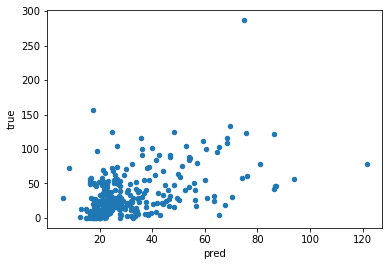

In [198]:
model = exp_sk.train_regressor('ols', scaled_train_x, train_y, random_state=0,random_search_cv=True,
                    n_iter=3, cv=5, n_jobs=3, verbose=0)

exp_sk.evaluate_regressor(model, scaled_test_x, test_y, scatter_plot=True)

{'test_RMSE': 29.936291399862213,
 'test_MAE': 20.102596654131762,
 'test_Exp_var': 0.27118390770820167,
 'test_r2': 0.2711839077082018,
 'test_pear_cor': 0.5207532119038746,
 'test_spea_cor': 0.4802027797047608,
 'test_kend_cor': 0.33302399435228236}

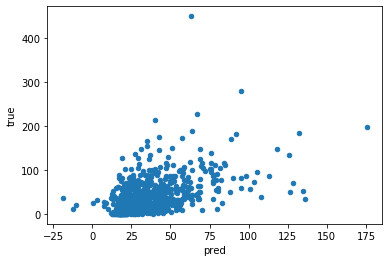

In [201]:
exp_sk.evaluate_regressor(model, scaled_train_x, train_y, scatter_plot=True)